# Generate the files

## Requirements

[rustup](https://rustup.rs/)
[python3](https://www.python.org/downloads/)

Maybe virtual env?

## Step by Step
We need to locate the directory where the replays are, in my case I dual-boot and mount windows to `/mnt/windows`

The final step takes around 32 seconds to process 3600 Replay files. This means about 110 replays per-second on a 16 Core machine.
```bash
$ git clone https://github.com/sebosp/s2protocol-rs
$ cd s2protocol-rs
$ mkdir ipcs/
$ cargo run -r -- --timing --source "/mnt/windows/Users/sebos/Documents/StarCraft II/Accounts/51504154/2-S2-1-8459957/Replays/Multiplayer/" --output ipcs/ write-arrow-ipc all'
$ cd ipcs
$ du -sh *
3.8M    details.ipc
27M     init_data.ipc
441M    stats.ipc
3.3G    unit_born.ipc
2.4G    unit_died.ipc
37M     upgrades.ipc
$ cd ..
$ pip install -r requirements.txt
$ jupyter lab
```


In [43]:
# import datashader as ds
import plotly.express as px
import polars as pl

pl.Config.set_tbl_width_chars(256)
pl.Config.set_fmt_str_lengths(256)

unit_born_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/unit_born.ipc")
unit_died_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/unit_died.ipc")
orig_details_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/details.ipc")
stats_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/stats.ipc")

In [44]:
freq_maps_df = (
    orig_details_df.group_by("title")
    .agg(pl.count())
    .filter(pl.col("count") > 25)
    .with_columns(pl.col("count").alias("map_count"))
    .select(["title", "map_count"])
)
details_df = orig_details_df.join(freq_maps_df, on="title", how="inner")
# unit_born_df.group_by("ext_replay_detail_player_name").agg(pl.count()).filter(
#    pl.col("count") > 10
# ).collect().sort("count", descending=True)#
# freq_maps_df.collect().sort("map_count", descending=True)
orig_details_df.filter(
    pl.col("ext_fs_replay_sha256")
    == "bcdc9f4529f33d8dc195e077a3efc8f2f5d171629589810258ce9c3b2884d606"
).select(
    [
        pl.col("ext_fs_replay_sha256"),
        pl.col("ext_datetime"),
        pl.col("ext_fs_replay_file_name"),
    ]
).collect().sort(
    "ext_datetime", descending=True
)

ext_fs_replay_sha256,ext_datetime,ext_fs_replay_file_name
str,datetime[ns],str
"""bcdc9f4529f33d8dc195e077a3efc8f2f5d171629589810258ce9c3b2884d606""",2023-09-01 16:27:20.513336,"""/mnt/windows/Users/sebos/Documents/StarCraft II/Accounts/51504154/2-S2-1-8459957/Replays/Multiplayer/Fields of Death (349).SC2Replay"""


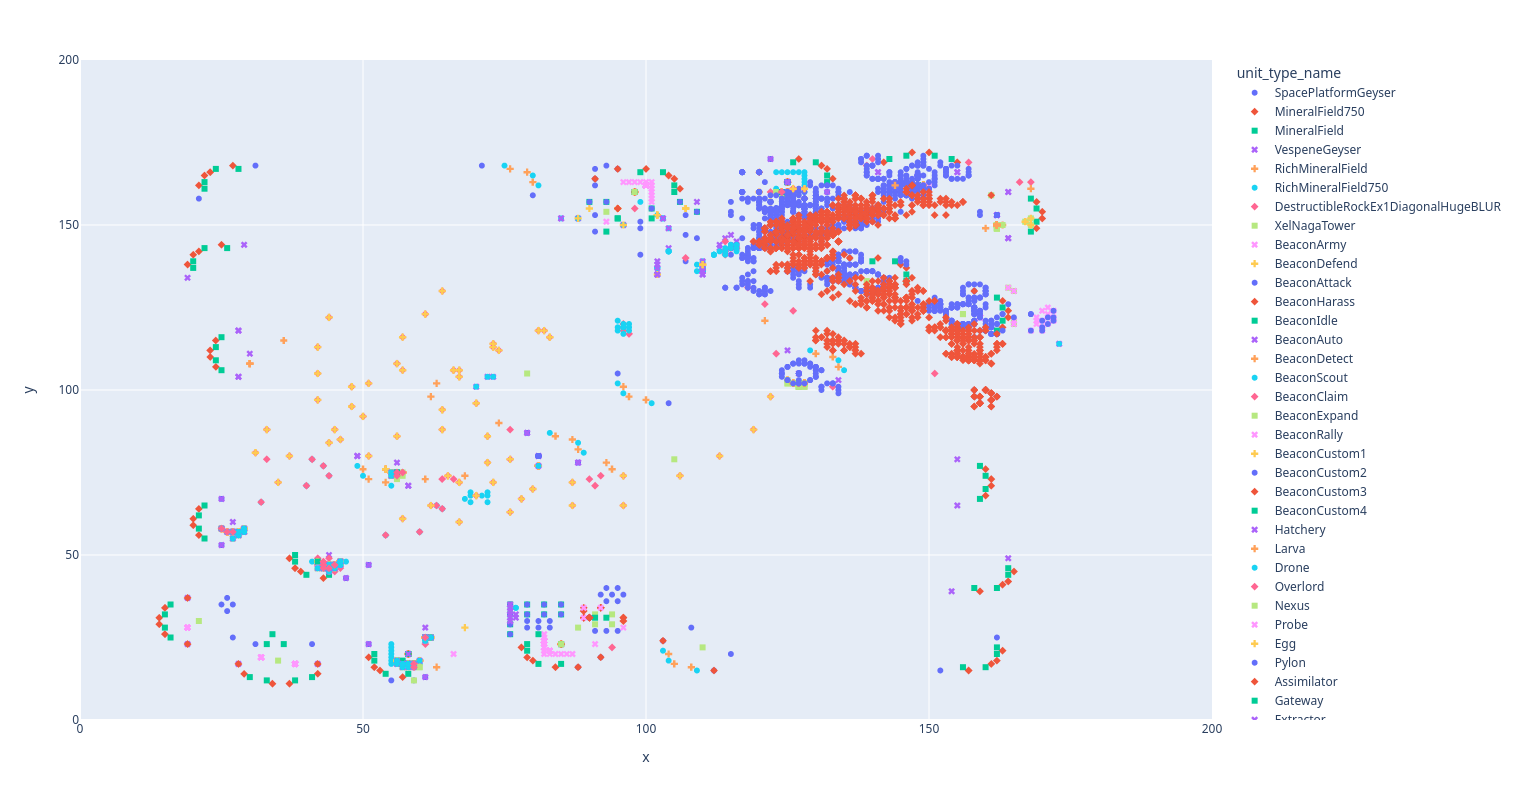

x,y,name_index,unit_tag_index,unit_type_name,ext_replay_loop
f32,f32,str,u32,str,i64
51.0,23.0,"""SpacePlatformGeyser0""",0,"""SpacePlatformGeyser""",0
29.0,14.0,"""MineralField7501""",1,"""MineralField750""",0
30.0,13.0,"""MineralField2""",2,"""MineralField""",0
33.0,12.0,"""MineralField3""",3,"""MineralField""",0
34.0,11.0,"""MineralField7504""",4,"""MineralField750""",0
37.0,11.0,"""MineralField7505""",5,"""MineralField750""",0
38.0,12.0,"""MineralField6""",6,"""MineralField""",0
41.0,13.0,"""MineralField7""",7,"""MineralField""",0
42.0,14.0,"""MineralField7508""",8,"""MineralField750""",0


In [50]:
unit_born_ec_le = (
    (
        unit_born_df.join(details_df, on="ext_fs_replay_sha256", how="inner")
        .filter(
            (
                pl.col("ext_fs_replay_sha256")
                == "bcdc9f4529f33d8dc195e077a3efc8f2f5d171629589810258ce9c3b2884d606"
            )
            # & (pl.col("unit_type_name") == "Hatchery")
            & (pl.col("unit_type_name") != "InvisibleTargetDummy")
        )
        .with_columns(
            pl.concat_str(pl.col("unit_type_name"), pl.col("unit_tag_index")).alias(
                "name_index"
            )
        )
        .select(
            [
                pl.col("x"),
                pl.col("y"),
                pl.col("name_index"),
                pl.col("unit_tag_index"),
                pl.col("unit_type_name"),
                pl.col("ext_replay_loop"),
            ]
        )
    )
    .collect()
    .sort("ext_replay_loop")
)

unit_born_map = px.scatter(
    unit_born_ec_le,
    x="x",
    y="y",
    color="unit_type_name",
    symbol="unit_type_name",
    width=1200,
    height=800,
    range_x=(0, 200),
    range_y=(0, 200),
    render_mode="svg",
)
unit_born_map.show()
unit_born_ec_le.head(100)

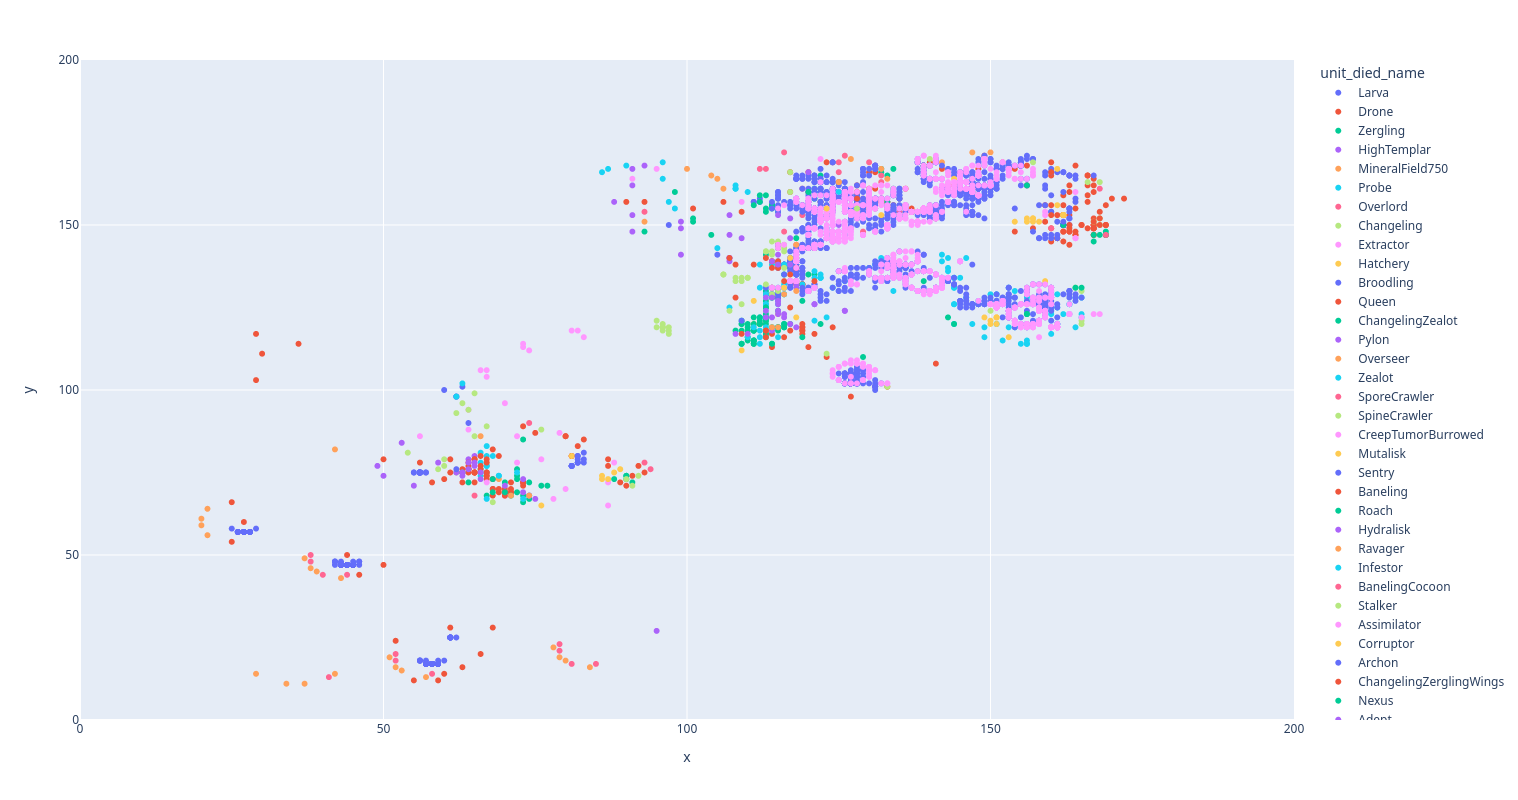

In [51]:
unit_died_test1 = (
    unit_died_df.filter(
        pl.col("ext_fs_replay_sha256")
        == "bcdc9f4529f33d8dc195e077a3efc8f2f5d171629589810258ce9c3b2884d606"
    )
    .select(["unit_died_name", "x", "y"])
    .collect()
)
fig = px.scatter(
    unit_died_test1,
    x="x",
    y="y",
    color="unit_died_name",
    width=1200,
    height=800,
    range_x=(0, 200),
    range_y=(0, 200),
    render_mode="svg",
)
fig.show()

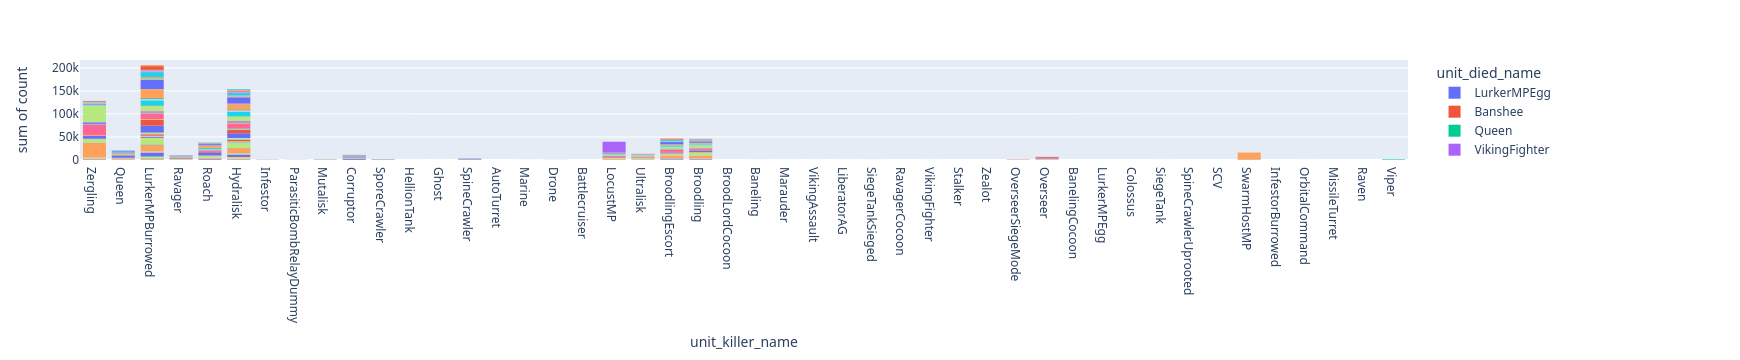

In [54]:
unit_died_ec_le = (
    unit_died_df.join(details_df, on="ext_fs_replay_sha256", how="inner")
    .filter(
        (pl.col("ext_replay_detail_killer_player_name") == "2-1-8459957-Sazed")
        & (pl.col("unit_killer_name") != "")
        & (pl.col("unit_died_name") != "InvisibleTargetDummy")
    )
    .select(
        [
            pl.col("ext_replay_detail_killer_player_name"),
            pl.col("unit_died_name"),
            pl.col("unit_tag_index"),
            pl.col("unit_killer_name"),
            pl.col("killer_unit_tag_index"),
            pl.col("ext_replay_loop"),
            pl.col("ext_replay_seconds"),
        ]
    )
)
unit_killer_to_died_freq = (
    unit_died_ec_le.group_by(["unit_killer_name", "unit_died_name"])
    .agg(pl.count().alias("count"))
    .collect()
    .sort("count")
)
unit_killer_freq = (
    unit_died_ec_le.group_by(["unit_killer_name"])
    .agg(pl.count().alias("count"))
    .collect()
    .sort("count")
)
unit_died_freq = (
    unit_died_ec_le.group_by(["unit_died_name"])
    .agg(pl.count().alias("count"))
    .collect()
    .sort("count")
)
hist = px.histogram(
    unit_killer_to_died_freq, x="unit_killer_name", y="count", color="unit_died_name")
hist.show()
# unit_killer_pie = px.pie(unit_killer_freq, names="unit_killer_name", values="count")
# unit_killer_pie.show()

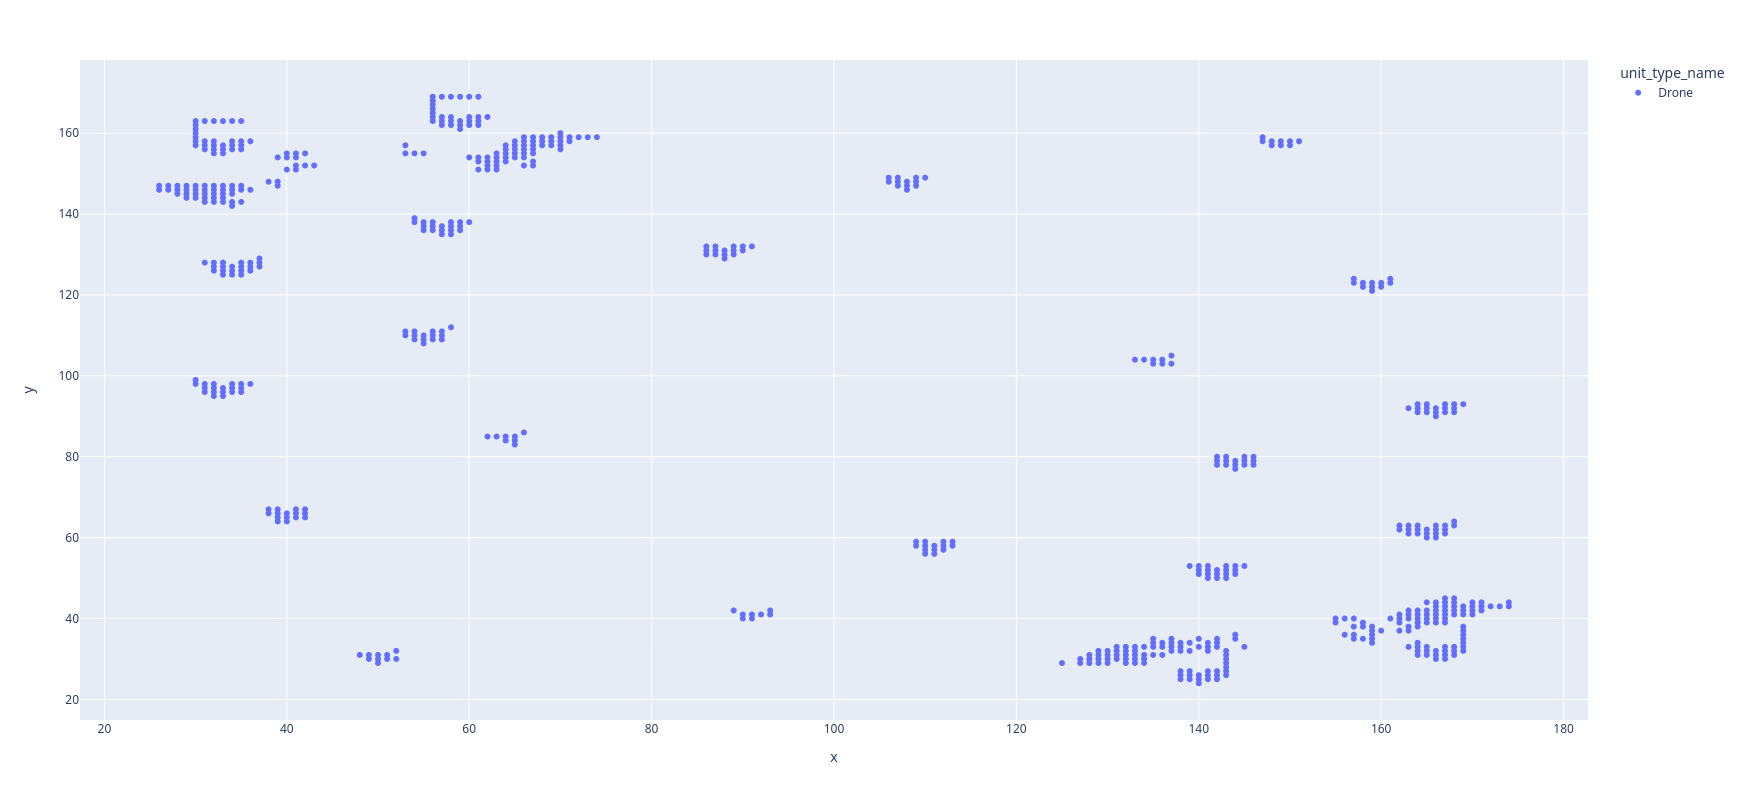

In [57]:
unit_born_ec_le = (
    unit_born_df.join(details_df, on="ext_fs_replay_sha256", how="inner")
    .filter(
        (pl.col("ext_replay_detail_player_name") == "2-1-8459957-Sazed")
        & (pl.col("title") == "Emerald City LE")
        & (pl.col("unit_type_name") == "Drone")
    )
    .select([pl.col("x"), pl.col("y"), pl.col("unit_type_name")])
    .group_by(["x", "y", "unit_type_name"])
    .agg(pl.sum("unit_type_name").alias("count"))
    .collect()
)
fig = px.scatter(unit_born_ec_le, x="x", y="y", color="unit_type_name", render_mode="svg", width=1600, height=800)
fig.show()

In [58]:
avg_drones_per_map = (
    unit_born_df.join(details_df, on="ext_fs_replay_sha256", how="inner")
    .filter(
        (pl.col("ext_replay_detail_player_name") == "2-1-8459957-Sazed")
        & (pl.col("unit_type_name") == "Drone")
    )
    .select(
        [
            pl.col("title"),
            pl.col("ext_fs_replay_sha256"),
            pl.col("unit_type_name"),
            pl.col("ext_replay_loop"),
            pl.col("ext_replay_detail_datetime"),
        ]
    )
    .group_by(["title", "ext_fs_replay_sha256", "ext_replay_detail_datetime"])
    .agg(
        [
            pl.col("unit_type_name").count().alias("count"),
            pl.col("ext_replay_loop").max().alias("max_loop"),
        ]
    )
    .filter(pl.col("max_loop") > 50)
    .with_columns((pl.col("max_loop") / pl.col("count")).alias("avg_per_loop"))
    .collect()
)
avg_drones_per_map.sort("ext_replay_detail_datetime", descending=True)

ColumnNotFoundError: ext_replay_detail_datetime

Error originated just after this operation:
FILTER [([(col("ext_replay_detail_player_name")) == (Utf8(2-1-8459957-Sazed))]) & ([(col("unit_type_name")) == (Utf8(Drone))])] FROM
INNER JOIN:
LEFT PLAN ON: [col("ext_fs_replay_sha256")]

    Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/unit_born.ipc
    PROJECT */14 COLUMNS
RIGHT PLAN ON: [col("ext_fs_replay_sha256")]
  INNER JOIN:
  LEFT PLAN ON: [col("title")]

      Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/details.ipc
      PROJECT */21 COLUMNS
  RIGHT PLAN ON: [col("title")]
     SELECT [col("title"), col("map_count")] FROM
       WITH_COLUMNS:
       [col("count").alias("map_count")]
        FILTER [(col("count")) > (25)] FROM

        AGGREGATE
        	[count()] BY [col("title")] FROM

            Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/details.ipc
            PROJECT */21 COLUMNS
  END INNER JOIN
END INNER JOIN

Error originated just after this operation:
ErrorStateSync(AlreadyEncountered(not found: ext_replay_detail_datetime

Error originated just after this operation:
FILTER [([(col("ext_replay_detail_player_name")) == (Utf8(2-1-8459957-Sazed))]) & ([(col("unit_type_name")) == (Utf8(Drone))])] FROM
INNER JOIN:
LEFT PLAN ON: [col("ext_fs_replay_sha256")]

    Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/unit_born.ipc
    PROJECT */14 COLUMNS
RIGHT PLAN ON: [col("ext_fs_replay_sha256")]
  INNER JOIN:
  LEFT PLAN ON: [col("title")]

      Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/details.ipc
      PROJECT */21 COLUMNS
  RIGHT PLAN ON: [col("title")]
     SELECT [col("title"), col("map_count")] FROM
       WITH_COLUMNS:
       [col("count").alias("map_count")]
        FILTER [(col("count")) > (25)] FROM

        AGGREGATE
        	[count()] BY [col("title")] FROM

            Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/details.ipc
            PROJECT */21 COLUMNS
  END INNER JOIN
END INNER JOIN))
FILTER [([(col("ext_replay_detail_player_name")) == (Utf8(2-1-8459957-Sazed))]) & ([(col("unit_type_name")) == (Utf8(Drone))])] FROM
INNER JOIN:
LEFT PLAN ON: [col("ext_fs_replay_sha256")]

    Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/unit_born.ipc
    PROJECT */14 COLUMNS
RIGHT PLAN ON: [col("ext_fs_replay_sha256")]
  INNER JOIN:
  LEFT PLAN ON: [col("title")]

      Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/details.ipc
      PROJECT */21 COLUMNS
  RIGHT PLAN ON: [col("title")]
     SELECT [col("title"), col("map_count")] FROM
       WITH_COLUMNS:
       [col("count").alias("map_count")]
        FILTER [(col("count")) > (25)] FROM

        AGGREGATE
        	[count()] BY [col("title")] FROM

            Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/details.ipc
            PROJECT */21 COLUMNS
  END INNER JOIN
END INNER JOIN

Error originated just after this operation:
FILTER [(col("max_loop")) > (50)] FROM
ErrorStateSync(AlreadyEncountered(not found: ext_replay_detail_datetime

Error originated just after this operation:
FILTER [([(col("ext_replay_detail_player_name")) == (Utf8(2-1-8459957-Sazed))]) & ([(col("unit_type_name")) == (Utf8(Drone))])] FROM
INNER JOIN:
LEFT PLAN ON: [col("ext_fs_replay_sha256")]

    Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/unit_born.ipc
    PROJECT */14 COLUMNS
RIGHT PLAN ON: [col("ext_fs_replay_sha256")]
  INNER JOIN:
  LEFT PLAN ON: [col("title")]

      Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/details.ipc
      PROJECT */21 COLUMNS
  RIGHT PLAN ON: [col("title")]
     SELECT [col("title"), col("map_count")] FROM
       WITH_COLUMNS:
       [col("count").alias("map_count")]
        FILTER [(col("count")) > (25)] FROM

        AGGREGATE
        	[count()] BY [col("title")] FROM

            Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/details.ipc
            PROJECT */21 COLUMNS
  END INNER JOIN
END INNER JOIN

Error originated just after this operation:
ErrorStateSync(AlreadyEncountered(not found: ext_replay_detail_datetime

Error originated just after this operation:
FILTER [([(col("ext_replay_detail_player_name")) == (Utf8(2-1-8459957-Sazed))]) & ([(col("unit_type_name")) == (Utf8(Drone))])] FROM
INNER JOIN:
LEFT PLAN ON: [col("ext_fs_replay_sha256")]

    Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/unit_born.ipc
    PROJECT */14 COLUMNS
RIGHT PLAN ON: [col("ext_fs_replay_sha256")]
  INNER JOIN:
  LEFT PLAN ON: [col("title")]

      Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/details.ipc
      PROJECT */21 COLUMNS
  RIGHT PLAN ON: [col("title")]
     SELECT [col("title"), col("map_count")] FROM
       WITH_COLUMNS:
       [col("count").alias("map_count")]
        FILTER [(col("count")) > (25)] FROM

        AGGREGATE
        	[count()] BY [col("title")] FROM

            Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/details.ipc
            PROJECT */21 COLUMNS
  END INNER JOIN
END INNER JOIN))
FILTER [([(col("ext_replay_detail_player_name")) == (Utf8(2-1-8459957-Sazed))]) & ([(col("unit_type_name")) == (Utf8(Drone))])] FROM
INNER JOIN:
LEFT PLAN ON: [col("ext_fs_replay_sha256")]

    Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/unit_born.ipc
    PROJECT */14 COLUMNS
RIGHT PLAN ON: [col("ext_fs_replay_sha256")]
  INNER JOIN:
  LEFT PLAN ON: [col("title")]

      Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/details.ipc
      PROJECT */21 COLUMNS
  RIGHT PLAN ON: [col("title")]
     SELECT [col("title"), col("map_count")] FROM
       WITH_COLUMNS:
       [col("count").alias("map_count")]
        FILTER [(col("count")) > (25)] FROM

        AGGREGATE
        	[count()] BY [col("title")] FROM

            Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/details.ipc
            PROJECT */21 COLUMNS
  END INNER JOIN
END INNER JOIN))
ErrorStateSync(AlreadyEncountered(not found: ext_replay_detail_datetime

Error originated just after this operation:
FILTER [([(col("ext_replay_detail_player_name")) == (Utf8(2-1-8459957-Sazed))]) & ([(col("unit_type_name")) == (Utf8(Drone))])] FROM
INNER JOIN:
LEFT PLAN ON: [col("ext_fs_replay_sha256")]

    Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/unit_born.ipc
    PROJECT */14 COLUMNS
RIGHT PLAN ON: [col("ext_fs_replay_sha256")]
  INNER JOIN:
  LEFT PLAN ON: [col("title")]

      Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/details.ipc
      PROJECT */21 COLUMNS
  RIGHT PLAN ON: [col("title")]
     SELECT [col("title"), col("map_count")] FROM
       WITH_COLUMNS:
       [col("count").alias("map_count")]
        FILTER [(col("count")) > (25)] FROM

        AGGREGATE
        	[count()] BY [col("title")] FROM

            Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/details.ipc
            PROJECT */21 COLUMNS
  END INNER JOIN
END INNER JOIN))
FILTER [([(col("ext_replay_detail_player_name")) == (Utf8(2-1-8459957-Sazed))]) & ([(col("unit_type_name")) == (Utf8(Drone))])] FROM
INNER JOIN:
LEFT PLAN ON: [col("ext_fs_replay_sha256")]

    Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/unit_born.ipc
    PROJECT */14 COLUMNS
RIGHT PLAN ON: [col("ext_fs_replay_sha256")]
  INNER JOIN:
  LEFT PLAN ON: [col("title")]

      Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/details.ipc
      PROJECT */21 COLUMNS
  RIGHT PLAN ON: [col("title")]
     SELECT [col("title"), col("map_count")] FROM
       WITH_COLUMNS:
       [col("count").alias("map_count")]
        FILTER [(col("count")) > (25)] FROM

        AGGREGATE
        	[count()] BY [col("title")] FROM

            Ipc SCAN /home/seb/git/s2protocol-rs/ipcs/details.ipc
            PROJECT */21 COLUMNS
  END INNER JOIN
END INNER JOIN

/home/seb/git/polars/venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



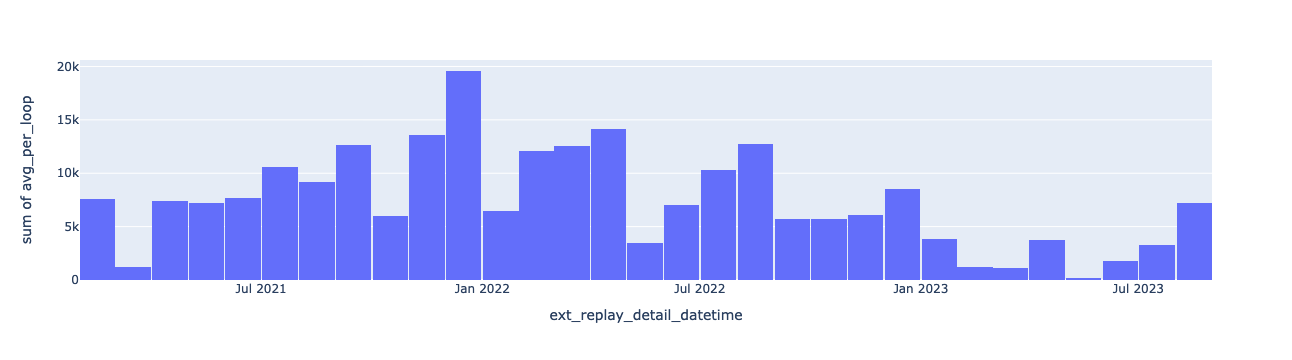

In [71]:
fig = px.histogram(avg_drones_per_map, x="ext_replay_detail_datetime", y="avg_per_loop")
fig.show()

In [ ]:
df_unit_born_details_join = (
    unit_born_df.join(details_df, on="ext_fs_replay_sha256", how="inner")
    .filter(
        (pl.col("ext_replay_detail_player_name") == "2-1-8459957-Sazed")
        & (pl.col("unit_type_name") != "InvisibleTargetDummy")
        & (~pl.col("unit_type_name").str.starts_with("Beacon"))
        & (~pl.col("unit_type_name").str.ends_with("Geyser"))
        & (~pl.col("unit_type_name").str.starts_with("LabMineralField"))
        & (~pl.col("unit_type_name").str.starts_with("RichMineralField"))
        & (~pl.col("unit_type_name").str.starts_with("MineralField"))
    )
    .select([pl.col("title"), pl.col("unit_type_name")])
    .group_by(["title", "unit_type_name"])
    .agg(pl.col("unit_type_name").count().alias("count"))
    .filter(pl.col("count") > 200)
    .collect()
    .sort("count", descending=True)
)